In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [2]:
# Load Auto MPG dataset

auto = fetch_openml(name="autoMpg", version=1, as_frame=True)
df = auto.frame.copy()
auto


{'data':     cylinders  displacement  horsepower  weight  acceleration model origin
 0           8         307.0       130.0    3504          12.0    70      1
 1           8         350.0       165.0    3693          11.5    70      1
 2           8         318.0       150.0    3436          11.0    70      1
 3           8         304.0       150.0    3433          12.0    70      1
 4           8         302.0       140.0    3449          10.5    70      1
 ..        ...           ...         ...     ...           ...   ...    ...
 393         4         140.0        86.0    2790          15.6    82      1
 394         4          97.0        52.0    2130          24.6    82      2
 395         4         135.0        84.0    2295          11.6    82      1
 396         4         120.0        79.0    2625          18.6    82      1
 397         4         119.0        82.0    2720          19.4    82      1
 
 [398 rows x 7 columns],
 'target': 0      18.0
 1      15.0
 2      18.0
 3  

In [3]:

print(df.info())
df = df.dropna()

print(df.shape)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   cylinders     398 non-null    category
 1   displacement  398 non-null    float64 
 2   horsepower    392 non-null    float64 
 3   weight        398 non-null    int64   
 4   acceleration  398 non-null    float64 
 5   model         398 non-null    category
 6   origin        398 non-null    category
 7   class         398 non-null    float64 
dtypes: category(3), float64(4), int64(1)
memory usage: 17.8 KB
None
(392, 8)


,cylinders,displacement,horsepower,weight,acceleration,model,origin,class
0,8,307.0,130.0,3504,12.0,70,1,18.0
1,8,350.0,165.0,3693,11.5,70,1,15.0
2,8,318.0,150.0,3436,11.0,70,1,18.0
3,8,304.0,150.0,3433,12.0,70,1,16.0
4,8,302.0,140.0,3449,10.5,70,1,17.0


In [ ]:
list_mpg = df["class"].value_counts()
print(len(list_mpg))

print(list_mpg)


127
class
13.0    20
14.0    19
18.0    17
15.0    16
26.0    14
        ..
28.1     1
24.2     1
30.7     1
22.4     1
44.0     1
Name: count, Length: 127, dtype: int64


In [5]:
y = df['class'].values.astype(float)
x = df.drop(columns=['class']).values.astype(float)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42 )

x_mean = x_train.mean(axis=0)
x_std = x_train.std(axis=0)
x_train = (x_train - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(313, 7) (79, 7)
(313,) (79,)


In [6]:
class LinearRegression:
    def __init__(self, lr=0.1, epochs=1000):
        self.w = None
        self.b = 0.0
        self.lr = lr
        self.epochs = epochs
        self.train_losses = []

    def predict(self, x):
        return x @ self.w + self.b

    def mse_loss(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    def update_weights(self, x, y_true):
        n = x.shape[0]
        y_pred = self.predict(x)

        loss = y_true - y_pred
        dw = (-2/n) * (x.T @ loss)
        db = (-2/n) * np.sum(loss)

        self.w -= self.lr * dw
        self.b -= self.lr * db

    def fit(self, x, y, verbose_every=100):
        n_features = x.shape[1]
        self.w = np.zeros(n_features)
        self.train_losses = []

        for epoch in range(1, self.epochs + 1):
            self.update_weights(x, y)

            y_pred = self.predict(x)
            loss = self.mse_loss(y, y_pred)
            self.train_losses.append(float(loss))

            if verbose_every and epoch % verbose_every == 0:
                print(f"Epoch {epoch}/{self.epochs} - Train MSE: {loss:.6f}")

        return self.train_losses


Epoch 100/1000 - Train MSE: 22.174777
Epoch 200/1000 - Train MSE: 12.007722
Epoch 300/1000 - Train MSE: 11.608503
Epoch 400/1000 - Train MSE: 11.453673
Epoch 500/1000 - Train MSE: 11.345859
Epoch 600/1000 - Train MSE: 11.267251
Epoch 700/1000 - Train MSE: 11.208632
Epoch 800/1000 - Train MSE: 11.164052
Epoch 900/1000 - Train MSE: 11.129563
Epoch 1000/1000 - Train MSE: 11.102486
Test MSE: 11.253801


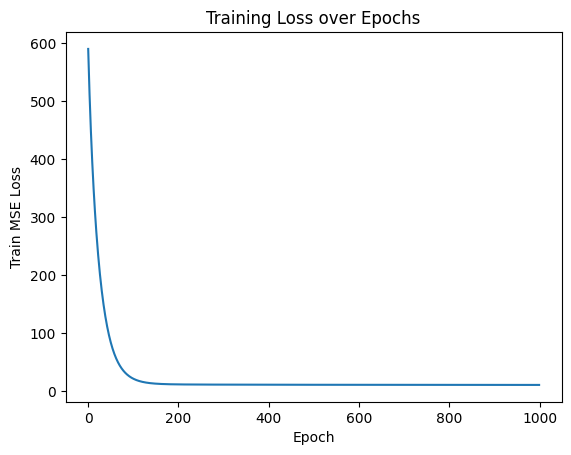

In [7]:
linear_model = LinearRegression(lr=0.01, epochs=1000)
linear_model.fit(x_train, y_train)

y_pred = linear_model.predict(x_test)
test_mse = linear_model.mse_loss(y_test, y_pred)

print(36*"=")
print(f"Test MSE: {test_mse:.6f}")
plt.plot(linear_model.train_losses)
plt.xlabel("Epoch")
plt.ylabel("Train MSE Loss")
plt.title("Training Loss over Epochs")
plt.show()

In [8]:
print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)

(313, 7)
(79, 7)
(313,)
(79,)


In [9]:
class MLP:
    def __init__(self, layer_size, lr=0.003, epochs=1000, batch_size=32, seed=42):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size

        self.input_size = layer_size[0]
        self.output_size = layer_size[-1]
        self.layers = layer_size[1:-1]
        self.train_losses = []

        # mỗi phần tử là 1 ma trận W, b giữa 2 layer liên tiếp
        self.w = []
        self.b = []

        rng = np.random.default_rng(seed)


        for i in range(len(layer_size) - 1):
            fan_in = layer_size[i]
            fan_out = layer_size[i+1]

            weight_matrix = rng.normal(0.0, np.sqrt(2.0 / fan_in), size=(fan_in, fan_out))
            bias_vector = np.zeros((1, fan_out))

            self.w.append(weight_matrix)
            self.b.append(bias_vector)

    # MSE 
    def mse_loss(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    def mse_grad(self, y_true, y_pred):
        m = y_true.shape[0]
        return (2.0 / m) * (y_pred - y_true)

    # ReLU
    def leru(self, x):
        return np.maximum(0, x)

    def leru_derivative(self, x):
        return np.where(x > 0, 1.0, 0.0)

    # Chạy từ đầu đến đuôi
    def forward(self, X):
        A = X
        A_list = [A]   # A0 = X
        Z_list = []

        L = len(self.w)
        for l in range(L):
            Z = A @ self.w[l] + self.b[l]
            Z_list.append(Z)

            if l < L - 1:
                A = self.leru(Z)
            else:
                A = Z  # linear output
            A_list.append(A)

        y_hat = A
        cache = (A_list, Z_list)
        return y_hat, cache


    def predict(self, X):
        y_hat, _ = self.forward(X)
        return y_hat

    # Backprop: tính gradient cho mọi W,b ----
    def backward(self, y_true, y_hat, cache):
        A_list, Z_list = cache
        L = len(self.w)

        dW = [None] * L
        db = [None] * L

        # gradient tại output
        dA = self.mse_grad(y_true, y_hat)   # (batch, output)

        for l in reversed(range(L)):
            A_prev = A_list[l]  # (batch, size_l)

            if l == L - 1:
                # output linear => dZ = dA
                dZ = dA
            else:
                # hidden => dZ = dA * ReLU'(Z)
                dZ = dA * self.leru_derivative(Z_list[l])

            dW[l] = A_prev.T @ dZ
            db[l] = np.sum(dZ, axis=0, keepdims=True)

            if l > 0:
                dA = dZ @ self.w[l].T

        return dW, db

    # ---- 1 bước train trên 1 batch ----
    def train_step(self, Xb, yb):
        # đảm bảo y là (batch, output_size)
        if yb.ndim == 1:
            yb = yb.reshape(-1, 1)
        elif yb.ndim == 2 and yb.shape[1] != self.output_size:
            # nếu lỡ truyền shape lạ, cố ép về (batch, output_size)
            yb = yb.reshape(-1, self.output_size)

        y_hat, cache = self.forward(Xb)
        loss = self.mse_loss(yb, y_hat)

        dW, db = self.backward(yb, y_hat, cache)

        # update
        for l in range(len(self.w)):
            self.w[l] -= self.lr * dW[l]
            self.b[l] -= self.lr * db[l]

        return float(loss)

    # ---- Fit: loop epochs + mini-batch ----
    def fit(self, X, y, verbose_every=100, shuffle=True):
        n = X.shape[0]
        self.train_losses = []

        for epoch in range(1, self.epochs + 1):
            if shuffle:
                idx = np.random.permutation(n)
                Xs = X[idx]
                ys = y[idx]
            else:
                Xs = X
                ys = y

            batch_losses = []
            for start in range(0, n, self.batch_size):
                Xb = Xs[start:start + self.batch_size]
                yb = ys[start:start + self.batch_size]
                batch_losses.append(self.train_step(Xb, yb))

            epoch_loss = float(np.mean(batch_losses))
            self.train_losses.append(epoch_loss)

            if verbose_every and epoch % verbose_every == 0:
                print(f"Epoch {epoch}/{self.epochs} - Train MSE: {epoch_loss:.6f}")

        return self.train_losses


Epoch 100/1000 - Train MSE: 6.158678
Epoch 200/1000 - Train MSE: 5.074977
Epoch 300/1000 - Train MSE: 4.155808
Epoch 400/1000 - Train MSE: 3.717065
Epoch 500/1000 - Train MSE: 2.539169
Epoch 600/1000 - Train MSE: 1.989639
Epoch 700/1000 - Train MSE: 4.078914
Epoch 800/1000 - Train MSE: 1.748870
Epoch 900/1000 - Train MSE: 3.674282
Epoch 1000/1000 - Train MSE: 1.658945
Test MSE: 7.397999


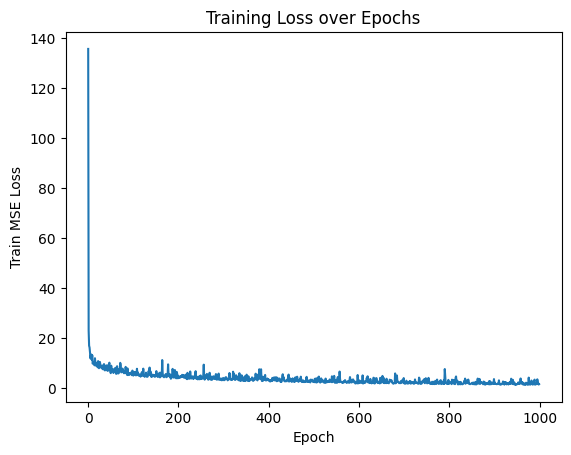

In [10]:
d = x_train.shape[1]
mlp_model = MLP([d, 64, 64, 1], lr=0.003, epochs=1000, batch_size=32)

mlp_model.fit(x_train, y_train, verbose_every=100)

y_pred = mlp_model.predict(x_test).reshape(-1)   # về (n,)
test_mse = np.mean((y_test - y_pred) ** 2)
print(36*"=")
print(f"Test MSE: {test_mse:.6f}")
plt.plot(mlp_model.train_losses)
plt.xlabel("Epoch")
plt.ylabel("Train MSE Loss")
plt.title("Training Loss over Epochs")
plt.show()
